In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'/usr/local/opt/apache-spark/libexec'

In [2]:
import pandas as pd
import random
import numpy as np

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler
from pyspark.sql.functions import udf, struct
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType, ArrayType
from pyspark.sql import SQLContext
import time
import matplotlib.pyplot as plt
import seaborn as sns

from utils import tools, data_preprocessing
from eALS import eALS
from ALS import ALS

In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
#conf = pyspark.SparkConf().setAppName('appName').setMaster('master')
conf = pyspark.SparkConf().set('spark.driver.host','127.0.0.1')
sc = pyspark.SparkContext(master='local', appName='myAppName',conf=conf)
#sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

In [4]:
def load_data(rows):
    data_path = "data/data_yelp.csv"

    data = data_preprocessing("data/yelp_rating.txt", data_path, rows=rows)

    rating_df = spark.read.format("csv")\
        .option("header", "true")\
        .option("inferSchema", "true")\
        .option("delimiter", ",")\
        .load(data_path)

    rating_rdd = rating_df.rdd

    # Input variables
    rating_list = rating_rdd.collect()

    # utils
    tool = tools(rating_list, data_path)
    R = tool.set_data_matrix()
    return R, data, rating_list

In [ ]:
data_path = "data/data_yelp.csv"
max_rows = 731669
percentage_data = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1]
time_perf_eALS_rdd = []
time_perf_eALS_df = []
score_perf_eALS_rdd = []
score_perf_eALS_df = []

for perc in percentage_data:
    R, data, rating_list = load_data(round(max_rows*perc))
    tool = tools(rating_list, data_path)
    
    MF_eALS = eALS(R)
    
    start = time.time()
    U_rdd, V_rdd = MF_eALS.fit_rdd(10, sc)
    end = time.time()
    time_perf_eALS_rdd.append(end - start)
    print(end - start)
    
    rmse_eALS_rdd = tool.rmse(U_rdd, V_rdd)
    score_perf_eALS_rdd.append(rmse_eALS_rdd)
    print(rmse_eALS_rdd)
    
    start = time.time()
    U_df, V_df = MF_eALS.fit_df(10, sc, spark, sqlContext)
    end = time.time()
    time_perf_eALS_df.append(end - start)
    print(end - start)
    
    rmse_eALS_df = tool.rmse(U_df, V_df)
    score_perf_eALS_df.append(rmse_eALS_df)
    print(rmse_eALS_df)
    
    print("Data %.3f%% done" %perc)
    

### 1 iteration with bigger datasets
1.3717880249023438
0.1906577790748896
1.5067369937896729
0.18133567201634856
Data 0.005% done
4.303585767745972
0.2271665797451013
4.283921003341675
0.24858503792460995
Data 0.010% done
19.242976903915405
0.26194109619726147
17.29573106765747
0.268988701094786
Data 0.020% done
29.13528299331665
0.23224850023719806
29.786492109298706
0.24420068979289336
Data 0.030% done
390.469526052475
0.18605390346565884
393.6787152290344
0.17708183525515353
Data 0.040% done
947.7439050674438
0.13687425574321513
987.423760175705
0.14904469273598436
Data 0.050% done
5219.773576974869
0.132640680902776
4977.440925359726
0.13668186641875488
Data 0.100% done

### 10 iteration with bigger datasets
14.401893138885498
2.6644268585361104
15.605443000793457
2.617139739481923
Data 0.005% done
49.539230823516846
2.643011757798002
56.279747009277344
2.70579753923311
Data 0.010% done
199.7611358165741
2.5336031939826107
201.57259583473206
2.5324046628654258
Data 0.020% done
368.5860240459442
2.3154901590613446
363.32819294929504
2.399199348745057
Data 0.030% done
3958.833958864212
2.263400144977772
4372.368039131165
2.167447795359282
Data 0.040% done
6398.275675773621
2.0757431153848236
6463.523674964905
2.023811971921003
Data 0.050% done

In [ ]:
max_rows = 731669
percentage_data = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1]
time_perf_ALS_rdd = []
time_perf_ALS_df = []
score_perf_ALS_rdd = []
score_perf_ALS_df = []
data_path = "data/data_yelp.csv"

for perc in percentage_data:
    R, data, rating_list = load_data(round(max_rows*perc))
    tool = tools(rating_list, data_path)
    
    MF_ALS = ALS(R, rating_list)
    
    start = time.time()
    U_rdd, V_rdd = MF_ALS.fit_rdd(10, sc)
    end = time.time()
    time_perf_ALS_rdd.append(end - start)
    print(end - start)
    
    rmse_ALS_rdd = tool.rmse(U_rdd, V_rdd.T)
    score_perf_ALS_rdd.append(rmse_ALS_rdd)
    print(rmse_ALS_rdd)
    
    start = time.time()
    U_df, V_df = MF_ALS.fit_df(10, sc, spark, sqlContext)
    end = time.time()
    time_perf_ALS_df.append(end - start)
    print(end - start)
    
    rmse_ALS_df = tool.rmse(U_df, V_df.T)
    score_perf_ALS_df.append(rmse_ALS_df)
    print(rmse_ALS_df)
    
    print("Data %.3f%% done" %perc)

### 1 iteration with bigger datasets
0.9939000606536865
0.04537975766978716
0.9738810062408447
0.06442192787919308
Data 0.005% done
1.3272011280059814
0.1231687557257913
1.8093268871307373
0.12287815983322176
Data 0.010% done
7.18476414680481
0.20793071272480704
8.069774150848389
0.2275215768680764
Data 0.020% done
26.8104829788208
0.1761782514281292
28.763697862625122
0.20140886247166812
Data 0.030% done
104.12651205062866
0.1535683876711319
103.38635492324829
0.15349687868091197
Data 0.040% done
230.45151019096375
0.12217747674773342
233.75937414169312
0.12896224785463328
Data 0.050% done
695.0577821731567
0.11082466608841371
674.6917440891266
0.11804774368396709
Data 0.100% done

### 10 iteration with bigger datasets
8.327862024307251
2.1350177002347586
9.569355964660645
2.1327777703517583
Data 0.005% done
24.746404886245728
2.782225989276042
28.812262773513794
2.922073119398629
Data 0.010% done
75.352130651474
3.2835495509804393
82.9613208770752
2.9965314373171537
Data 0.020% done
278.8325128555298
3.0586951451980138
288.56825590133667
3.0592273291213234
Data 0.030% done
982.1419711112976
2.7635457166697672
1028.788255929947
2.8484975407227098
Data 0.040% done
2331.251740217209
2.707991179060188
2232.3929619789124
2.638752219263093
Data 0.050% done

In [ ]:
max_rows = 731669
max_iters = [10, 20, 30, 40, 50, 75, 100]
time_iter_eALS_rdd = []
time_iter_eALS_df = []
score_iter_eALS_rdd = []
score_iter_eALS_df = []
data_path = "data/data_yelp.csv"

R, data, rating_list = load_data(round(max_rows*0.005))
MF_eALS = eALS(R)
tool = tools(rating_list, data_path)

for max_iter in max_iters:
    
    start = time.time()
    U_rdd, V_rdd = MF_eALS.fit_rdd(max_iter, sc)
    end = time.time()
    time_iter_eALS_rdd.append(end - start)
    print(end - start)
    
    rmse_eALS_rdd = tool.rmse(U_rdd, V_rdd)
    score_iter_eALS_rdd.append(rmse_eALS_rdd)
    print(rmse_eALS_rdd)
    
    start = time.time()
    U_df, V_df = MF_eALS.fit_df(max_iter, sc, spark, sqlContext)
    end = time.time()
    time_iter_eALS_df.append(end - start)
    print(end - start)
    
    rmse_eALS_df = tool.rmse(U_df, V_df)
    score_iter_eALS_df.append(rmse_eALS_df)
    print(rmse_eALS_df)
    
    print("Iterations %.1f done" %max_iter)


In [ ]:
max_rows = 731669
max_iters = [10, 20, 30, 40, 50, 75, 100]
time_iter_ALS_rdd = []
time_iter_ALS_df = []
score_iter_ALS_rdd = []
score_iter_ALS_df = []
data_path = "data/data_yelp.csv"

R, data, rating_list = load_data(round(max_rows*0.005))
MF_ALS = ALS(R, rating_list)
tool = tools(rating_list, data_path)

for max_iter in max_iters:

    start = time.time()
    U_rdd, V_rdd = MF_ALS.fit_rdd(max_iter, sc)
    end = time.time()
    time_iter_ALS_rdd.append(end - start)
    print(end - start)
    
    rmse_ALS_rdd = tool.rmse(U_rdd, V_rdd.T)
    score_iter_ALS_rdd.append(rmse_ALS_rdd)
    print(rmse_ALS_rdd)
    
    start = time.time()
    U_df, V_df = MF_ALS.fit_df(max_iter, sc, spark, sqlContext)
    end = time.time()
    time_iter_ALS_df.append(end - start)
    print(end - start)
    
    rmse_ALS_df = tool.rmse(U_df, V_df.T)
    score_iter_ALS_df.append(rmse_ALS_df)
    print(rmse_ALS_df)
    
    print("Iterations %.1f done" %max_iter)

## Iterations

In [5]:
time_iter_eALS_rdd = [12.940356731414795,26.655306100845337,41.15347504615784,54.639516830444336,69.89045286178589,102.97695207595825,147.07749891281128]
time_iter_eALS_df = [13.440707921981812,30.276834964752197,42.53443670272827,59.80083107948303,77.50299596786499,113.20527386665344,156.88548398017883]
score_iter_eALS_rdd = [0.018586585804913316,0.012721749166105271,0.007001528747966289,0.007170809631093114,0.006903840771200344,0.00540273452914323,0.004883415647603604]
score_iter_eALS_df = [0.018095064523764148,0.011306917563356264,0.007746829984296212,0.00788778288836454,0.011489785789499453,0.005352914807525057,0.005247635963314149]

time_iter_ALS_rdd = [4.784506797790527,8.179294109344482,12.682103157043457,16.17557692527771,20.055540084838867,30.004359006881714,39.95613121986389]
time_iter_ALS_df = [6.582417964935303,12.148053884506226,18.082287788391113,23.354425191879272,29.3037428855896,44.103511810302734,58.20622682571411]
score_iter_ALS_rdd = [0.006519003939076072,0.004703066667558621,0.0012177374908842015,0.0017101469645240998,0.001007662326985145,0.0006753523867165591,0.00045214649398443274]
score_iter_ALS_df = [0.006176277637029754,0.0027301168160606226,0.0017501131566105533,0.001737991629236727,0.0016916997554411585,0.0009574182433490511,0.00045295574035831296]



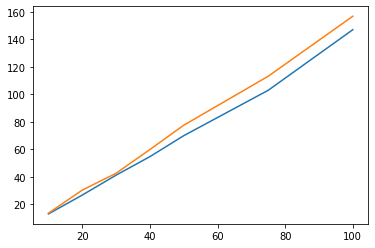

In [6]:
max_iters = [10, 20, 30, 40, 50, 75, 100]
sns.lineplot(x=max_iters, y=time_iter_eALS_rdd)
sns.lineplot(x=max_iters, y=time_iter_eALS_df)
plt.show()

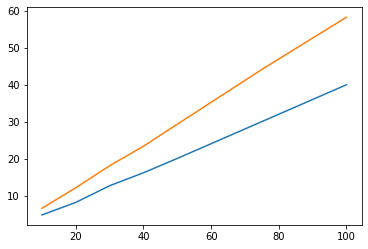

In [7]:
sns.lineplot(x=max_iters, y=time_iter_ALS_rdd)
sns.lineplot(x=max_iters, y=time_iter_ALS_df)
plt.show()

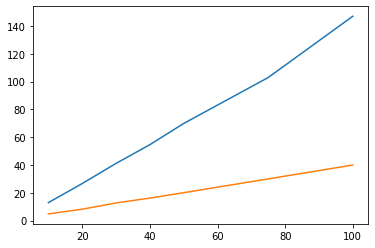

In [8]:
sns.lineplot(x=max_iters, y=time_iter_eALS_rdd)
sns.lineplot(x=max_iters, y=time_iter_ALS_rdd)
plt.show()

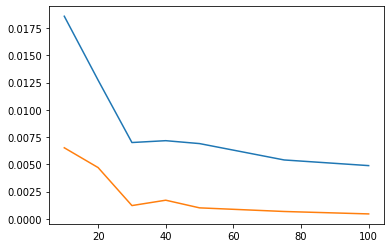

In [9]:
sns.lineplot(x=max_iters, y=score_iter_eALS_rdd)
sns.lineplot(x=max_iters, y=score_iter_ALS_rdd)
plt.show()

## Dataset size 10 iterations

In [42]:
time_perf_eALS_rdd = [14.40, 49.53, 199.76, 368.58, 3958.83, 5398.27]
time_perf_eALS_df = [15.6, 56.27, 201.57, 363.32, 4372.36, 5463.52]
score_perf_eALS_rdd = [2.66, 2.64, 2.53, 2.31, 2.26, 2.07]
score_perf_eALS_df = [2.61, 2.70, 2.53, 2.39, 2.16, 2.02]

time_perf_ALS_rdd = [8.32, 24.74, 75.35, 278.83, 982.14, 3331.25]
time_perf_ALS_df = [9.56, 28.81, 82.96, 288.56, 1028.78, 3232.39]
score_perf_ALS_rdd = [2.63, 2.78, 3.28, 3.05, 2.76, 2.70] 
score_perf_ALS_df = [2.63, 2.92, 2.99, 3.05, 2.84, 2.63]

In [43]:
percentage_data = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05]

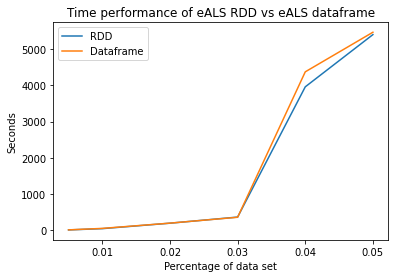

In [86]:
sns.lineplot(x=percentage_data, y=time_perf_eALS_rdd)
sns.lineplot(x=percentage_data, y=time_perf_eALS_df)
plt.title('Time performance of eALS RDD vs eALS dataframe')
plt.ylabel('Seconds')
plt.xlabel('Percentage of data set')
plt.legend(('RDD', 'Dataframe'))
plt.savefig('graphs/time_eALS_RDD_DF.png')
plt.show()

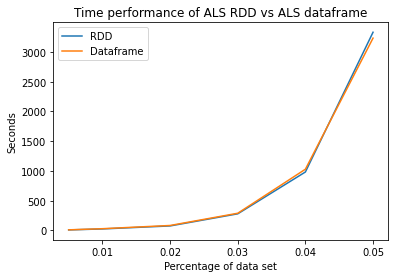

In [87]:
sns.lineplot(x=percentage_data, y=time_perf_ALS_rdd)
sns.lineplot(x=percentage_data, y=time_perf_ALS_df)
plt.title('Time performance of ALS RDD vs ALS dataframe')
plt.ylabel('Seconds')
plt.xlabel('Percentage of data set')
plt.legend(('RDD', 'Dataframe'))
plt.savefig('graphs/time_ALS_RDD_DF.png')
plt.show()

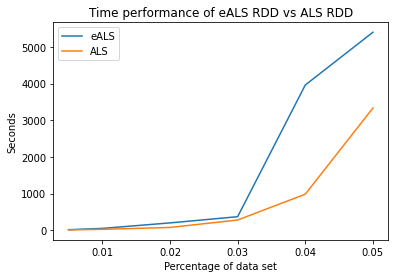

In [84]:
sns.lineplot(x=percentage_data, y=time_perf_eALS_rdd)
sns.lineplot(x=percentage_data, y=time_perf_ALS_rdd)
plt.title('Time performance of eALS RDD vs ALS RDD')
plt.ylabel('Seconds')
plt.xlabel('Percentage of data set')
plt.legend(('eALS', 'ALS'))
plt.savefig('graphs/time_eALS_ALS.png')
plt.show()

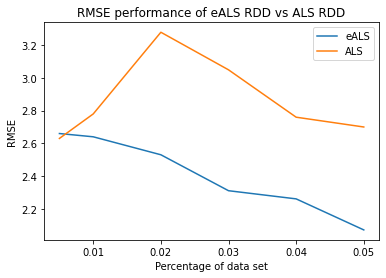

In [85]:
sns.lineplot(x=percentage_data, y=score_perf_eALS_rdd)
sns.lineplot(x=percentage_data, y=score_perf_ALS_rdd)
plt.title('RMSE performance of eALS RDD vs ALS RDD')
plt.ylabel('RMSE')
plt.xlabel('Percentage of data set')
plt.legend(('eALS', 'ALS'))
plt.savefig('graphs/RMSE_eALS_ALS.png')
plt.show()

## Dataset size 1 iterations

In [16]:
time_perf_eALS_rdd = [1.37, 4.30, 19.24, 29.13, 390.46, 947.74, 5219.77]
time_perf_eALS_df = [1.50, 4.28, 17.29, 29.78, 393.67, 987.42, 4977.44]
score_perf_eALS_rdd = [0.19, 0.22, 0.26, 0.23, 0.18, 0.13, 0.13]
score_perf_eALS_df = [0.18, 0.24, 0.26, 0.24, 0.17, 0.14, 0.13]

time_perf_ALS_rdd = [0.99, 1.32, 7.18, 26.81, 104.12, 230.45, 695.05]
time_perf_ALS_df = [0.97, 1.80, 8.06, 28.76, 103.38, 233.75, 674.69]
score_perf_ALS_rdd = [0.04, 0.12, 0.20, 0.17, 0.15, 0.12, 0.11]
score_perf_ALS_df = [0.06, 0.12, 0.22, 0.20, 0.15, 0.12, 0.11]

In [17]:
percentage_data = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1]

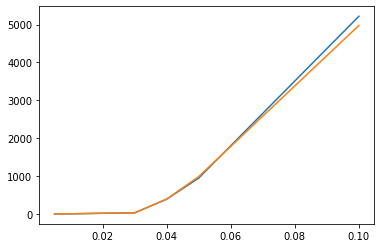

In [18]:
sns.lineplot(x=percentage_data, y=time_perf_eALS_rdd)
sns.lineplot(x=percentage_data, y=time_perf_eALS_df)
plt.show()

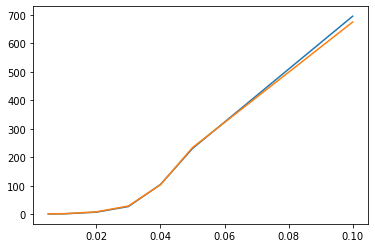

In [19]:
sns.lineplot(x=percentage_data, y=time_perf_ALS_rdd)
sns.lineplot(x=percentage_data, y=time_perf_ALS_df)
plt.show()

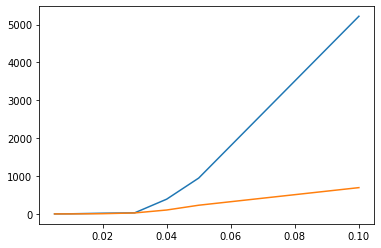

In [20]:
sns.lineplot(x=percentage_data, y=time_perf_eALS_rdd)
sns.lineplot(x=percentage_data, y=time_perf_ALS_rdd)
plt.show()

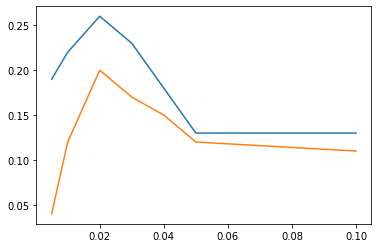

In [21]:
sns.lineplot(x=percentage_data, y=score_perf_eALS_rdd)
sns.lineplot(x=percentage_data, y=score_perf_ALS_rdd)
plt.show()